# Dataset Creation and Pre-Processing

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [ ]:
es600 = pd.read_csv("230507_es600_final.csv")
es600.shape

(7801, 70)

In [ ]:
es600 = es600.dropna(subset = "derivedEmissions")
es600.reset_index(drop=True, inplace=True)
es600.shape

(6239, 70)

In [ ]:
# dropping all rows that contain more than 20 nan values
threshold = 20

for index, row in es600.iterrows():
  if row.isna().sum() > threshold:
    es600.drop(es600.index[index], axis=0, inplace=True)

es600.shape

(6228, 70)

In [ ]:
# dropping columns with insufficent data and filtering columns to impute
drop_columns = []
columns_to_impute = []

for column in es600.columns:
    nan_count = es600[column].isna().sum()
    total_count = len(es600[column])
    nan_percentage = (nan_count / total_count) * 100

    if nan_percentage != 0 and nan_percentage <= 60:
      columns_to_impute.append(column)
    if nan_percentage > 60:
      drop_columns.append(column)

# dropping columns
es600.drop(columns = drop_columns, inplace = True)

# sorting the dataframe nicely by OrgId and FisYear
es600 = es600.sort_values(by = ["OrgId","FisYear"]).reset_index(drop = True)

es600.shape

(6228, 65)

In [ ]:
# imputing values first based on bfill and then on mean for each OrgId
grouped = es600.groupby('OrgId', group_keys=False)

def backward_fill(group):
    return group.fillna(method='bfill', limit=1)

def impute_with_mean(group):
    return group.fillna(group.mean(numeric_only = True))

es600 = grouped.apply(backward_fill)
es600 = grouped.apply(impute_with_mean)

es600.reset_index(drop=True, inplace=True)
es600.shape

(6228, 65)

In [ ]:
# filtering only for timeseries from 2015 to 2020
start = 2015
end = 2020

es600 = es600.loc[(es600.FisYear >= 2015) & (es600.FisYear <= 2020)]
es600.shape

(3093, 65)

In [ ]:
# imputing values based on the mean of sector for the given year
grouped = es600.groupby("econIdDesc", group_keys = False)

es600 = grouped.apply(impute_with_mean)

es600.reset_index(drop=True, inplace=True)
es600.shape

(3093, 65)

In [ ]:
# dropping last nan values and getting the final clean dataframe
es600 = es600.dropna(axis = 0)
es600.shape

(3033, 65)

In [ ]:
# statistical summary table
grouped = es600[["FisYear","emissionIntensity"]].groupby("FisYear")

ei_stat = grouped.describe()
ei_stat.columns = [column_name[1].capitalize() for column_name in ei_stat.columns.values]

skew = grouped.skew().rename(columns = {"emissionIntensity":"Skew"})
med = grouped.median().rename(columns = {"emissionIntensity":"Med"})

ei_stat = pd.concat([ei_stat.iloc[:,:2],med,ei_stat.iloc[:,2:]], axis = 1)
ei_stat["Skew"] = skew
ei_stat = ei_stat.round(decimals = 2)
ei_stat = ei_stat.drop(columns = ["Std","25%","50%","75%"])
print(ei_stat.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  Count &    Mean &    Med &   Min &      Max &  Skew \\
FisYear &        &         &        &       &          &       \\
\midrule
2015    &  488.0 &  192.43 &  24.97 &  0.02 &  6840.65 &  7.13 \\
2016    &  497.0 &  205.28 &  24.43 &  0.02 &  7433.79 &  6.61 \\
2017    &  499.0 &  188.35 &  23.11 &  0.01 &  6615.25 &  6.48 \\
2018    &  509.0 &  170.98 &  21.75 &  0.01 &  8165.81 &  8.44 \\
2019    &  519.0 &  154.48 &  19.03 &  0.02 &  6550.81 &  7.68 \\
2020    &  521.0 &  144.66 &  15.99 &  0.02 &  4475.85 &  6.66 \\
\bottomrule
\end{tabular}



<ipython-input-10-8b437e2f19e1>:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ei_stat.to_latex())


<ipython-input-43-0fb84005a287>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=es600["econIdDesc"], y=es600["emissionIntensity"], ax=ax1, palette="Oranges_r")
<ipython-input-43-0fb84005a287>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels)


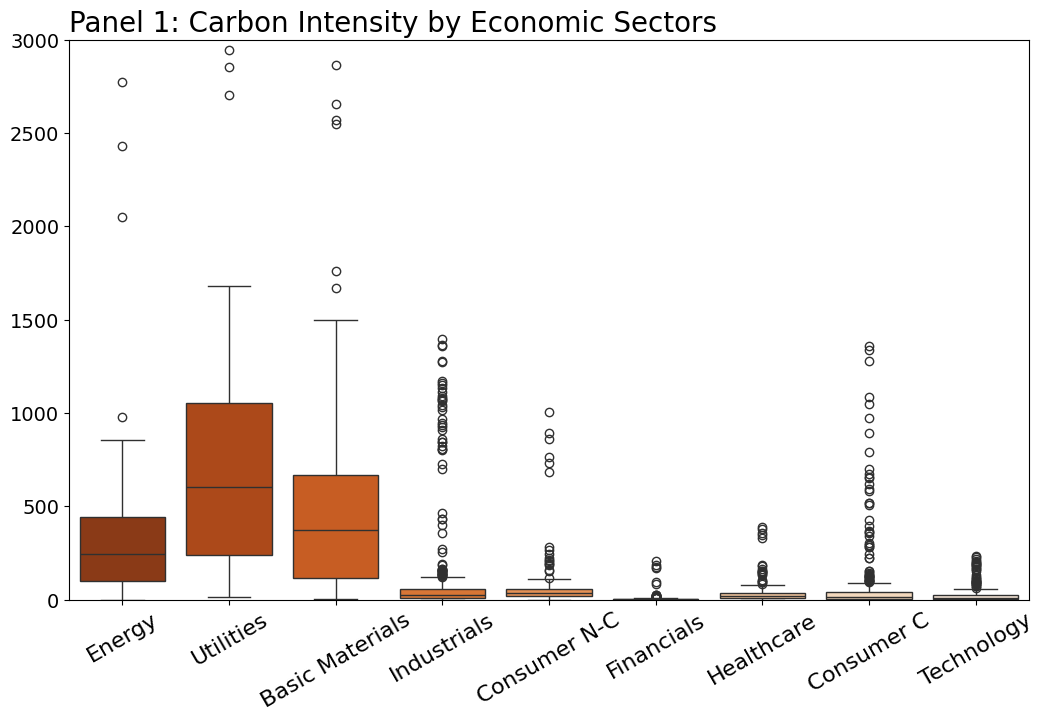

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 7))  # Create figure and axes objects

sns.boxplot(x=es600["econIdDesc"], y=es600["emissionIntensity"], ax=ax1, palette="Oranges_r")
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_ylim([0, 3000])
ax1.set_title("Panel 1: Carbon Intensity by Economic Sectors", loc="left", fontsize = 20)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30)

# Rename specific x tickers
rename_dict = {4: 'Consumer N-C', 7: 'Consumer C'}  # Specify indices and new labels
labels = [tick.get_text() for tick in ax1.get_xticklabels()]
for index, label in rename_dict.items():
    if 0 <= index < len(labels):
        labels[index] = label
ax1.set_xticklabels(labels)

ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='x', labelsize=16)


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    hspace=0.3)

plt.savefig('boxplots_ei_econId_sectors.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# printing out categorical variables before creating dummy variables
print(es600.IncomeGroup.unique())
print(es600.econIdDesc.unique())

['High income' 'Upper middle income']
['Energy' 'Utilities' 'Basic Materials' 'Industrials'
 'Consumer Non-Cyclicals' 'Financials' 'Healthcare' 'Consumer Cyclicals'
 'Technology']


In [ ]:
# encoding categorical variables
def encode_categorical_variables(data: pd.DataFrame, variables: list):

  end_encoded_df = pd.DataFrame()

  for variable in variables:

    encoded_df = pd.get_dummies(data[[variable]].copy())
    end_encoded_df = pd.concat([end_encoded_df,encoded_df], axis = 1)

  data = data.drop(columns = variables)
  data = pd.concat([data, end_encoded_df], axis=1)

  return data

In [ ]:
es600 = encode_categorical_variables(data = es600.copy(), variables = ["econIdDesc","IncomeGroup"])

In [ ]:
es600.to_csv("final_capstone_dataset.csv", index = False)

In [ ]:
# plotting industry trends
def plot_df_variables(data: pd.DataFrame, variables: list, aggfunc: str, title:str):

  fig = plt.figure(figsize = (17,14))
  fig.suptitle(title, y = 1, fontsize = 20, fontweight = "bold")

  n_year = len(data.FisYear.unique())
  n_variables = len(variables)
  n_plot = 1

  for variable in variables:

    pivot = pd.pivot_table(data = es600[["FisYear",variable]],
                             index = "FisYear",
                             values = variable,
                             aggfunc = aggfunc)

    ax = fig.add_subplot(n_variables//3 + 1,3,n_plot)
    pivot.plot(ax = ax,linewidth=2.5, color='orange')
    ax.set_title(variable, fontsize = 20, fontweight = "bold")
    ax.legend().remove()
    ax.set_ylabel("")
    ax.set_xlabel("")

    n_plot += 1

  plt.tight_layout()
  plt.savefig("industry_trends.pdf")
  plt.show()

  return

In [ ]:
cols = ["derivedEmissions","emissionIntensity","Energy Use Total",
        "ESG SCORE","CSR Strategy Score", 'Direct Energy/Energy Purchased Direct',
        'totalRevenue', 'propertyPlantEquipmentTotal', 'totalDebt']

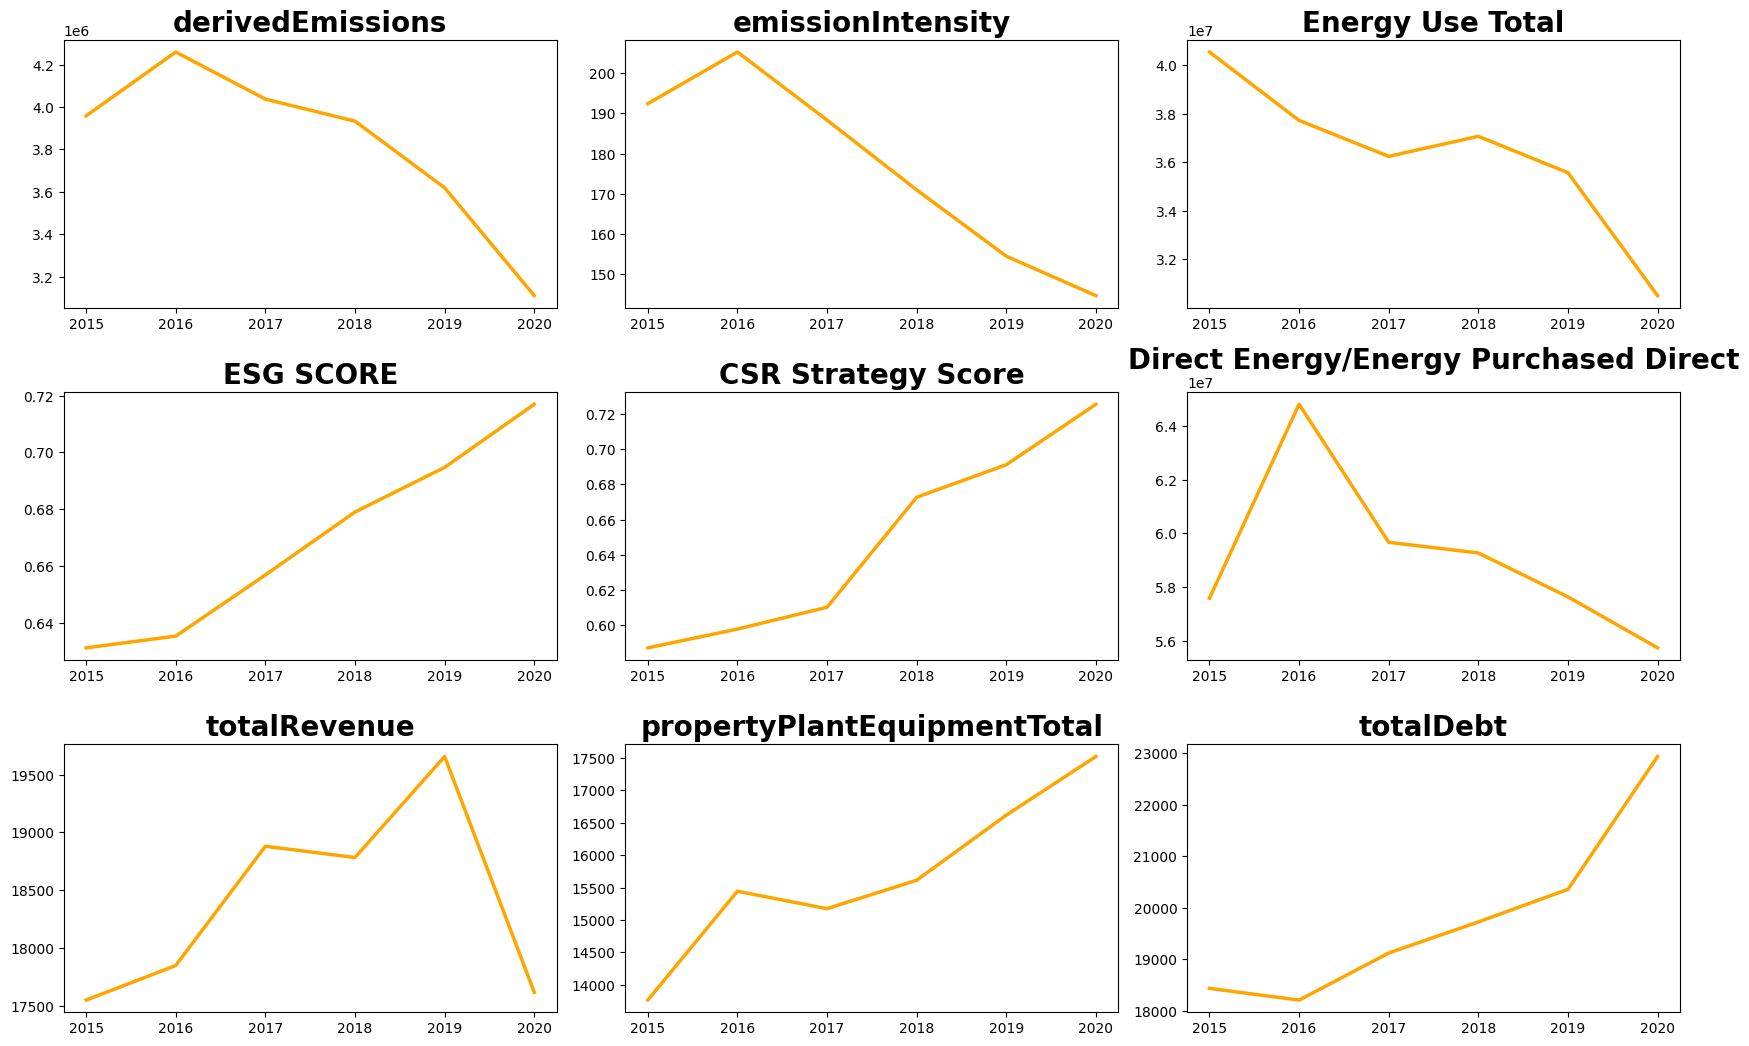

In [ ]:
plot_df_variables(data = es600.copy(),variables = cols, aggfunc = "mean", title = "")

# EDA with Shapash

In [ ]:
!pip install shapash

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from shapash.explainer.smart_explainer import SmartExplainer

In [ ]:
import random
import pandas as pd

In [ ]:
df = pd.read_csv("final_capstone_dataset.csv")

## Construction 1

In [ ]:
df = df.set_index(df["OrgName_x"] + "_" + df["FisYear"].astype(str))
df = df.loc[:,"derivedEmissions":]
df = df.drop(columns = ["CO2e Indirect Emissions, Scope 3","ISOCountryCodeDerived", "Region",'CO2 Equivalents Emission Total',
                        'CO2 Equivalents Emission Direct', 'CO2 Equivalents Emission Indirect',"emissionIntensity",
                        "Energy Use Total","Direct Energy/Energy Purchased Direct"])

In [ ]:
y = df['derivedEmissions']
X = df.drop(['derivedEmissions'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'max_depth': [5, 10, 15],  # Example values, you can adjust these
    'n_estimators': [10, 50, 100]  # Example values, you can adjust these
}

# Initialize RandomForestRegressor
model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)

# Perform grid search cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Re-train the model with the best parameters
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Make predictions
y_pred = pd.DataFrame(best_model.predict(X_test), columns=['derivedEmissions'], index=X_test.index)

Best Parameters: {'max_depth': 15, 'n_estimators': 100}


In [ ]:
xpl = SmartExplainer(model = best_model)
xpl.compile(x=X_test, y_pred=y_pred)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7ef7896aeef0>


In [ ]:
xpl.plot.features_importance()

In [ ]:
subset = random.choices(X_test.index, k =50)
xpl.plot.features_importance(selection=subset)

In [ ]:
xpl.plot.contribution_plot("propertyPlantEquipmentTotal")

In [ ]:
xpl.plot.local_plot(index=random.choice(X_test.index))

# UMAP

In [ ]:
!pip install umap-learn

In [1]:
import pandas as pd

In [4]:
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [5]:
import matplotlib.pyplot as plt

In [103]:
import seaborn as sns

In [127]:
df = pd.read_csv("final_capstone_dataset.csv")

In [128]:
risk_impact = ["insignificant", "minor", "significant", "major", "severe"]

## Handling Outliers - Trimming - NOT USED

* Trimming top and lower 5% tail of distribution for EI and DE

In [ ]:
# Calculate the lower and upper percentile thresholds
lower_percentile = 30
upper_percentile = 95

# Calculate the percentile values
lower_threshold = df['emissionIntensity'].quantile(lower_percentile / 100)
upper_threshold = df['emissionIntensity'].quantile(upper_percentile / 100)

# Exclude outliers based on the percentile thresholds
df = df[(df['emissionIntensity'] >= lower_threshold) & (df['emissionIntensity'] <= upper_threshold)]

## Construction 1

1.   Using only companies that are included in each year in the index (complete df)
2.   Doing it on aggreated data -> analysis on year basis




In [129]:
complete_list = []
for OrgId, temp in df.groupby("OrgId"):
  if len(temp) == 6:
    complete_list.append(OrgId)

In [130]:
complete_df = df.loc[df.OrgId.isin(complete_list)]

### Variaton 1 - using all features

In [89]:
X = complete_df.loc[:,"derivedEmissions":]
X = X.drop(columns = ["CO2e Indirect Emissions, Scope 3","ISOCountryCodeDerived", "Region",'CO2 Equivalents Emission Total',
                        'CO2 Equivalents Emission Direct', 'CO2 Equivalents Emission Indirect',"emissionIntensity",
                        "Energy Use Total","Direct Energy/Energy Purchased Direct", "derivedEmissions"])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-90-5767f44fab0c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df["cluster"] = clusters


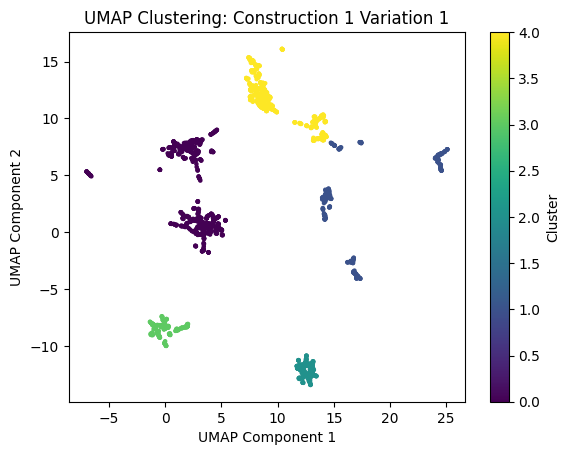

In [90]:
# Assuming df is your dataframe with high-dimensional data

# Step 1: Preprocess your data if necessary (e.g., scaling)
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply UMAP for dimensionality reduction
reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(X_scaled)

# Step 3: Perform clustering (for example, using KMeans)
num_clusters = 5  # You can adjust this based on your data
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(umap_embedding)
cluster_labels = kmeans.labels_
clusters = kmeans.fit_predict(X_scaled)
complete_df["cluster"] = clusters

# Step 4: Visualize the results
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.title('UMAP Clustering: Construction 1 Variation 1')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [97]:
pivot = complete_df.pivot_table(index = "cluster", columns = "FisYear", aggfunc = "mean")["emissionIntensity"]
mapping_dict = {}
for index, (cluster, mean) in enumerate(pivot.mean(axis = 1).sort_values().iteritems()):
  mapping_dict[cluster] = risk_impact[index] + "_clusterNumber_" + str(cluster)

<ipython-input-97-c21a568ae385>:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  pivot = complete_df.pivot_table(index = "cluster", columns = "FisYear", aggfunc = "mean")["emissionIntensity"]
<ipython-input-97-c21a568ae385>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, (cluster, mean) in enumerate(pivot.mean(axis = 1).sort_values().iteritems()):


In [99]:
pivot1 = pivot.sort_values(by = 2015).rename(index = mapping_dict).rename_axis("Risk Exposure")

In [110]:
complete_df['risk_exposure'] = complete_df['cluster'].map(mapping_dict)

<ipython-input-110-e4d2034e8364>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df['risk_exposure'] = complete_df['cluster'].map(mapping_dict)


In [ ]:
complete_df.pivot_table(index = columns)

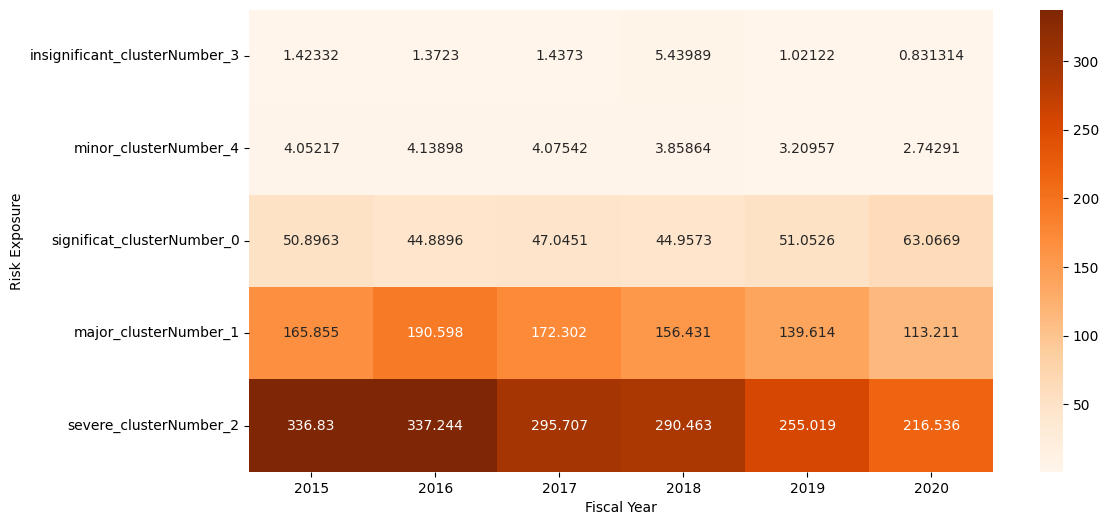

In [109]:
# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot1, annot=True, cmap='Oranges', fmt='g') # 'g' format displays numbers
plt.title('')
plt.xlabel('Fiscal Year')
plt.ylabel('Risk Exposure')
plt.show()

In [95]:
pivot1.to_excel("UMAP_construction1_variation1.xlsx")

In [111]:
import pandas as pd

# Sample DataFrame
data = {
    'Year': [2019, 2019, 2019, 2020, 2020, 2020, 2021, 2021, 2021],
    'Risk_Level': ['Low', 'Medium', 'High', 'Low', 'Medium', 'High', 'Low', 'Medium', 'High'],
    'Sector': ['Tech', 'Finance', 'Healthcare', 'Tech', 'Finance', 'Healthcare', 'Tech', 'Finance', 'Healthcare']
}

df = pd.DataFrame(data)

# Create a pivot table to count occurrences of sectors for each year and risk level
pivot_table = df.pivot_table(index='Sector', columns=['Year', 'Risk_Level'], aggfunc='size')

# Get the most occurring sector for each year and risk level
most_occuring_sector = pivot_table.idxmax()

# Create a new DataFrame with the most occurring sector for each year and risk level
result_df = most_occuring_sector.reset_index(name='Most_Occurring_Sector')
result_df.rename(columns={'Year': 'Year', 'Risk_Level': 'Risk_Exposure'}, inplace=True)

# Pivot the result DataFrame to have years as columns and "risk_exposure" as index
pivot_result = result_df.pivot(index='Risk_Exposure', columns='Year', values='Most_Occurring_Sector')

print(pivot_result)

Year                 2019        2020        2021
Risk_Exposure                                    
High           Healthcare  Healthcare  Healthcare
Low                  Tech        Tech        Tech
Medium            Finance     Finance     Finance


### Variation 2 - using only important features (shapash)

In [131]:
X = complete_df[["propertyPlantEquipmentTotal","rnd/sales","GDP PPP","enterpriseValue","capex/fixedAssets","cogs/sales","cf/sales","sales/employee"]]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-132-f983e3295ee4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df["cluster"] = clusters


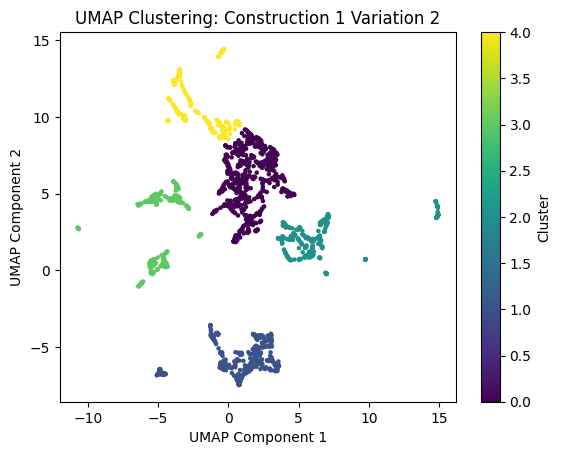

In [132]:
# Assuming df is your dataframe with high-dimensional data

# Step 1: Preprocess your data if necessary (e.g., scaling)
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply UMAP for dimensionality reduction
reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(X_scaled)

# Step 3: Perform clustering (for example, using KMeans)
num_clusters = 5  # You can adjust this based on your data
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(umap_embedding)
cluster_labels = kmeans.labels_
clusters = kmeans.fit_predict(X_scaled)
complete_df["cluster"] = clusters

# Step 4: Visualize the results
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.title('UMAP Clustering: Construction 1 Variation 2')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [133]:
pivot = complete_df.pivot_table(index = "cluster", columns = "FisYear", aggfunc = "mean")["emissionIntensity"]
mapping_dict = {}
for index, (cluster, mean) in enumerate(pivot.mean(axis = 1).sort_values().iteritems()):
  mapping_dict[cluster] = risk_impact[index] + "_clusterNumber_" + str(cluster)

<ipython-input-133-edae3cb0e428>:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  pivot = complete_df.pivot_table(index = "cluster", columns = "FisYear", aggfunc = "mean")["emissionIntensity"]
<ipython-input-133-edae3cb0e428>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, (cluster, mean) in enumerate(pivot.mean(axis = 1).sort_values().iteritems()):


In [134]:
pivot

FisYear,2015,2016,2017,2018,2019,2020
cluster,,,,,,
0,319.476743,310.624528,291.516363,308.820472,281.548882,245.525856
1,49.731620,62.243693,60.381346,40.122867,47.394870,38.524171
2,2.321641,1.372300,2.083631,1.390385,2.316257,1.412702
3,42.307556,41.019813,38.113420,36.043377,33.390804,28.394737
4,381.206225,359.220909,310.154702,265.208745,250.898445,266.004399


In [135]:
mapping_dict

{2: 'insignificant_clusterNumber_2',
 3: 'minor_clusterNumber_3',
 1: 'significant_clusterNumber_1',
 0: 'major_clusterNumber_0',
 4: 'severe_clusterNumber_4'}

In [136]:
pivot2 = pivot.sort_values(by = 2015).rename(index = mapping_dict).rename_axis("Risk Exposure")

In [140]:
cluster_labels.astype(str)

array(['4', '4', '4', ..., '1', '1', '1'], dtype='<U11')

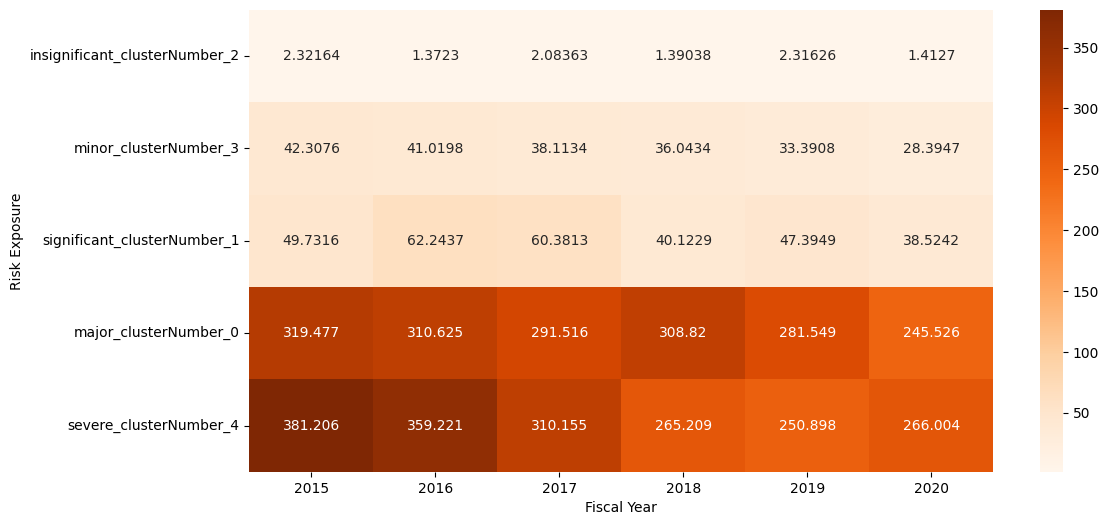

In [137]:
# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot2, annot=True, cmap='Oranges', fmt='g') # 'g' format displays numbers
plt.title('')
plt.xlabel('Fiscal Year')
plt.ylabel('Risk Exposure')
plt.show()

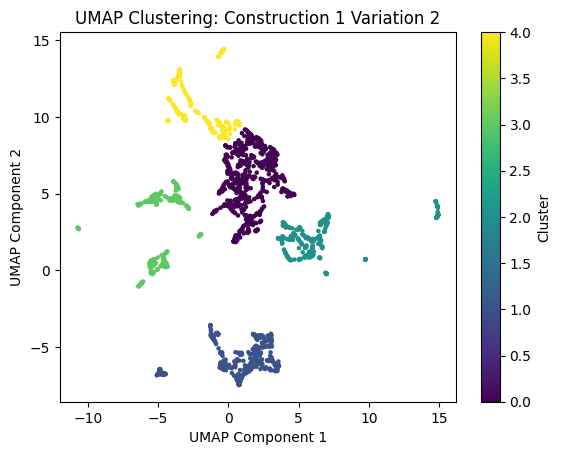

In [142]:
# Step 4: Visualize the results
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.title('UMAP Clustering: Construction 1 Variation 2')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Cluster')
plt.show()

## Construction 2

## Variation 1 - using all features

## Variation 2 - using only important features (shapash)